# Explainable AI - Model Explanation

## Model & Data

The model we decided to explain is a Random Forest classifier. The Random Forest is an ensemble method which relies on multitude of decision trees. Even though a decision tree is a white-box model, Random Forest becomes hard to visualize and interpret once it reaches a certain level of complexity. Random Forest is widely used and is one of the elementary machine learning models. That is why we decided to focus our efforts on trying to find methods which would help to make this model class more interpretable. 

The goal of our model is to predict whether a patient is at a high risk of getting a heart attack in the future. We trained our model on a simple heart attack dataset which contains patients’ medical information. We chose this dataset because we believe that medicine is one of the areas where interpretability of a model is crucial. We downloaded the dataset from Kaggle (https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset), from the user Rashik Rahman. During the training of our model, we were not trying to achieve a perfect model, on the contrary, for example, we intentionally left in the dataset redundant features to show that our methods for explaining the model can point out their redundancy. 

Detailed description of the features in the dataset: 
- age: Age of the patient in years 
- sex: Gender of the patient (1 = male; 0 = female) 
- cp: chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic) 
- trtbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- restecg: resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slp: the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)
- caa: number of major vessels (0-3) colored by flourosopy
- thall: 2 = normal; 1 = fixed defect; 3 = reversable defect; result of thallium stress test
- target: 0 = less chance of heart attack 1 = more chance of heart attack
    

In [1]:
# Imports
import csv
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from helpers import Hyperparameter_Search

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns
import lime
import operator
from lime import lime_tabular
from IPython.display import display
from PIL import Image
import shap
from sklearn.manifold import TSNE
from exmatrix import ExplainableMatrix

## Model Training

In [2]:
# Load up the data
file_name = "data/heart.csv"
with open(file_name, "r") as f:
    pre_data = csv.reader(f, delimiter=",")
    data = [row for row in pre_data]

headers, data_array = data[0], np.asarray(data[1:], dtype=float)
X, y = data_array[:, :-1], data_array[:, -1]

In [3]:
# Look for the (roughly) ideal hyperparameters for the Random Forest
hyp_grid = {
    "n_estimators": [10, 50, 100, 150, 200],
    "criterion": ["entropy", "gini"],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "random_state": [66]
}

HS = Hyperparameter_Search(model_class=RandomForestClassifier, hyp_grid=hyp_grid, scaler=StandardScaler,
                           random_state=66)

HS.hyperparameter_search(X=X, y=y, n_folds=5)

hyp = HS.get_best_combo()

In [4]:
# Train our Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66, shuffle=True, stratify=None)

clf = RandomForestClassifier(**hyp)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of the Random Forest:", accuracy)


Accuracy of the Random Forest: 0.8681318681318682


## Global Feature Importance

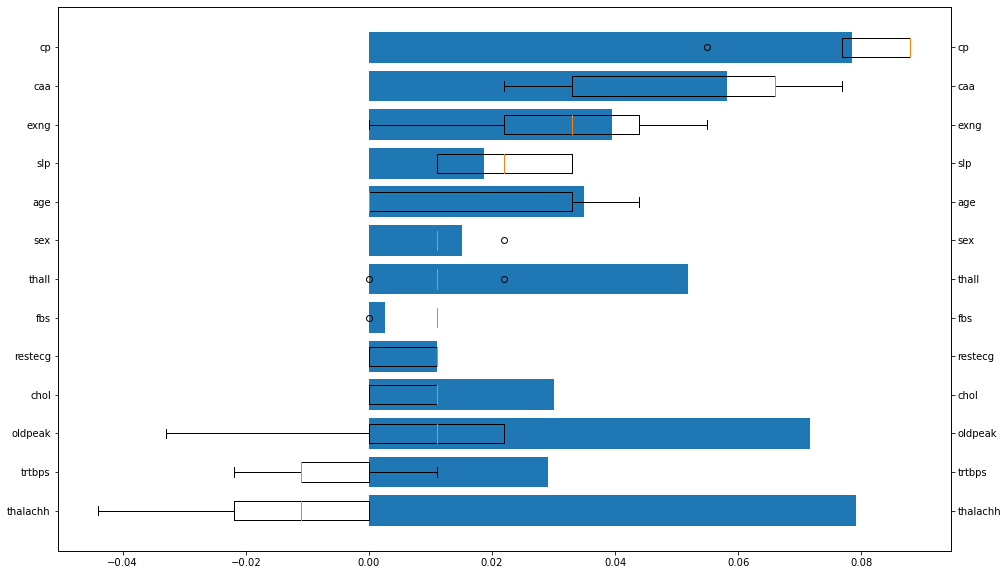

In [5]:
# Feature Importance

feature_importance = pd.Series(clf.feature_importances_, index=headers[:-1])

# Permutation Importance

perm = permutation_importance(clf, X_test, y_test, )

feature_perm_importance = pd.Series(perm['importances_mean'], index=headers[:-1])

sorted_idx = perm.importances_mean.argsort()


fig = plt.figure(figsize=(16,10))
ax = fig.subplots()
ax.barh(feature_importance.index[sorted_idx], feature_importance[sorted_idx] / feature_importance.max() * perm.importances_mean.max(), align='center')
ax2 = ax.twinx()
ax2.boxplot(
    perm.importances[sorted_idx].T, vert=False, labels=feature_perm_importance.index[sorted_idx]
)

ax2.set_ylim((ax.get_ylim()[0] + 1, ax.get_ylim()[1] + 1))
plt.show()

In the plot above the overall feature importance of each feature in the model is shown. The plot is sorted by the mean permutation importance, additionally the impurity based feature importance of the random forest model is shown (as rescaled barchart).

These are two ways to visualize which features the model deems important and which not.
Permutation importance sometimes believes a feature to be unimportant or less important then it is if there is correlation with other features. Therefore, correlation needs to be checked to determine whether features are really unimportant.
Impurity based feature importance normally has a bias towards features with a huge numerical range in contrast to features with a small number of possible values. 

Due to the weaknesses described above this graph cannot be used to make any kind of definitive statement about the model on its own. However, it can be used to gain a feeling about what the model deems important and if applied to a model without correlation between features a statement about the model could be made (at this point we have no information about the correlation between features).

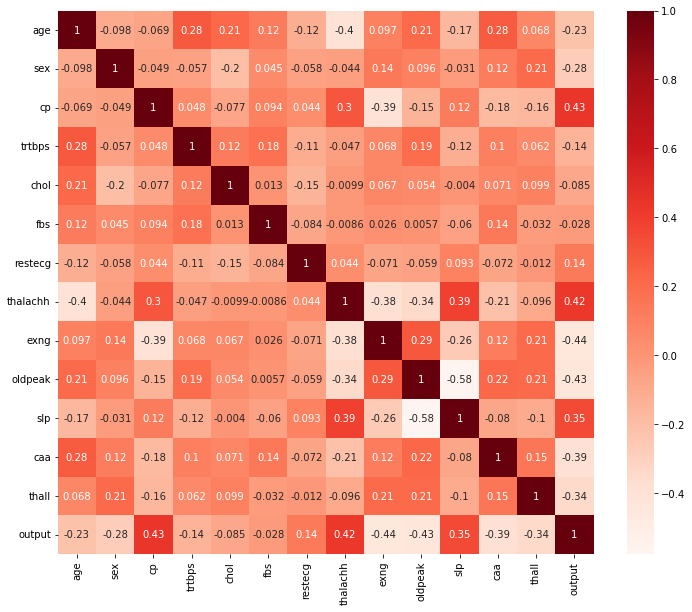

In [6]:
plt.figure(figsize=(12,10))
cor = pd.DataFrame(data_array, columns=headers).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

There do not seem to be any strong correlations between features, therefore, the permutation importance should be reliable.

## SHAP Values

For a deeper understanding of the models decisions we can compute  SHAP values. SHAP values give information about how strong features contributed to a decision and in what way.

Below there is an example, in which the model came to the conclusion that the patient has a heart disease with 70% certainty:

In [7]:
# SHAP Values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

df_X_test = pd.DataFrame(X_test, columns=headers[:-1])

shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[1][0], df_X_test.columns)

The most important features which contributed to the decision are:
- caa : number of major vessels (0-3) colored by flourosopy 
- cp : the type of chest pain
- thalachh : the maximum heart rate
- thall : result of thallium stress test
With sufficient knowledge of the domain (for example: as a doctor) one can now deduct whether the decision made was a reasonable decision or not.

If the decision or more specifically the features which the decision was based on seem unreasonable the decision has to be made manually. If the final decision is the same as that of the model one could try to figure out why there is a correlation and if there is a valid reasoning that can be done or if it is just an error in the model for example due to over-fitting.

Below there are the SHAP values of the whole dataset which was used:

In [8]:
shap.force_plot(explainer.expected_value[1], shap_values[1], df_X_test.columns)

Now let's try to extract information about the model's decisions in them more global manner. The plot below shows the SHAP values grouped by feature instead of sample:

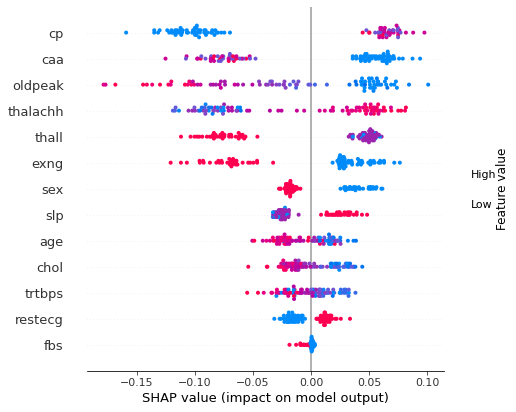

In [9]:
shap.summary_plot(shap_values[1], df_X_test)

More blue dots are lower values, while more red dots are higher values. The position on the X axis shows the impact of the feature on the decision in its respecive context. The values are sorted by their overall influence on the decision of the model (in regard to this dataset).

The strongest indicator for the decision (on avarage) seems to be cp, which is the type of chest pain the patient has. cp can take four different values, three of which indicate heart disease, the last one (most likely no pain) indicates no heart disease.
In a similar manner all features can be said to have low values indicating one tendency and high values indicating the other, this is more clear for discrete values than for values with huge ranges.
Age seems to be an exception to some extent because both low values and high values can be found on the same side of the plot.

## The Trust Mashine (Experimental)

The method is intended to give non-expert model users confidence about the model's decision by the fact that there are many similar cases which also were classified correctly like this.

Below the SHAP values of the dataset on our model were taken and projected using t-SNE. the hypothesis is, that values which are not near the decision border and in dense clusters will probably be safe decisions which can be trusted.

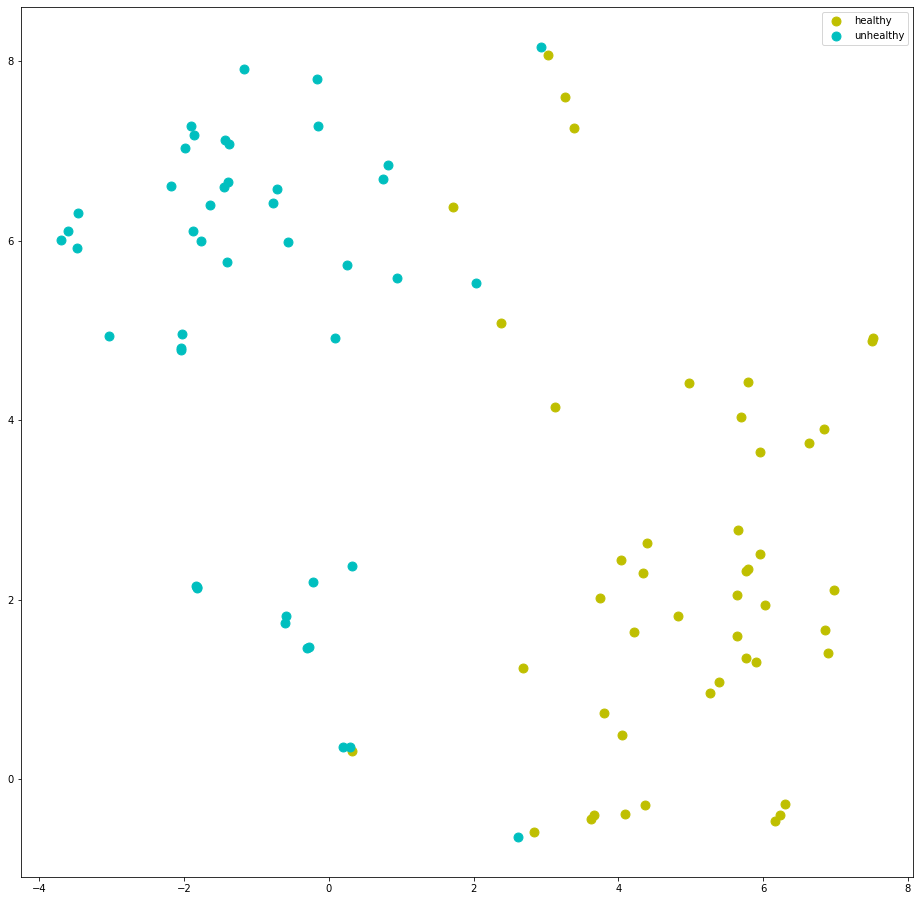

In [10]:
# Projection
tsne = TSNE(n_components=2, random_state=1, init='random', learning_rate='auto')
combo =np.concatenate((shap_values[0], shap_values[1]), axis=1)
X_2d = tsne.fit_transform(combo)

pred = clf.predict(X_test)

plt.figure(figsize=(16, 16))
plt.scatter(X_2d[pred==0, 0], X_2d[pred==0, 1], c='y', s=80, label='healthy')
plt.scatter(X_2d[pred==1, 0], X_2d[pred==1, 1], c='c', s=80, label='unhealthy')
plt.legend()
plt.show()

No hyperparameter-tuning was done since the default look ok and we do not have much expetancy about how many clusters should be visible.

Next we look for clusters in the projection:

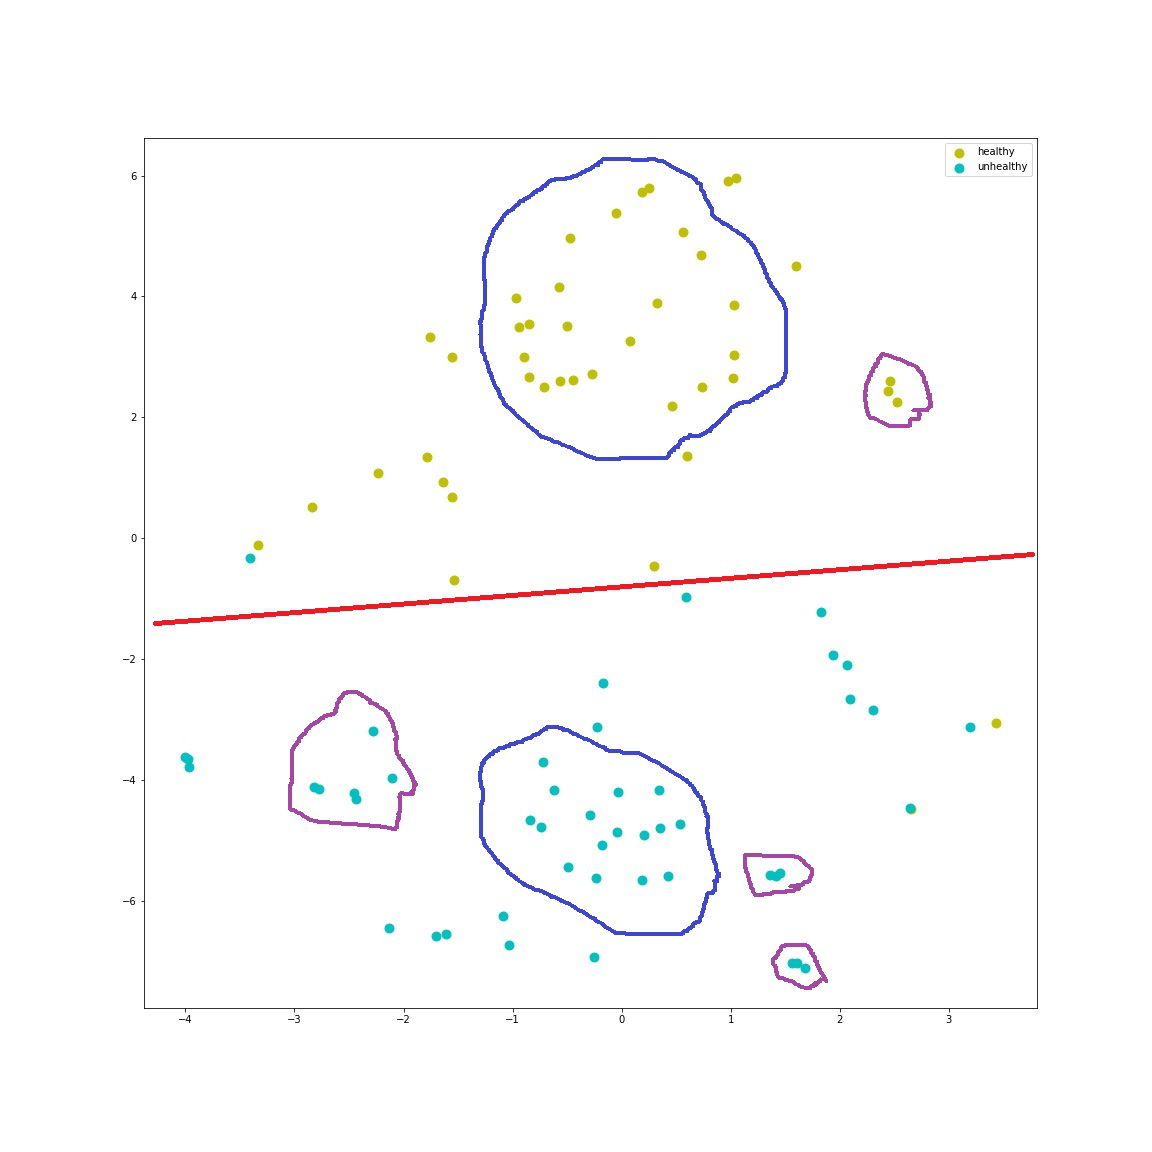

In [11]:
display(Image.open('images/borders_SHAP.png'))

The red line is our gues for the decision border. The blue clusters seem trustworthy acording to our hypothesis. The violet clusters might be real but they might also be artefacts or to close to the decision border, since or model only has an accuracy o 88% and mainly false-positives (unhealthy=positive; this is visible in the check below).

Lastly we check whether our hypothesis is correct by checking the true labels:

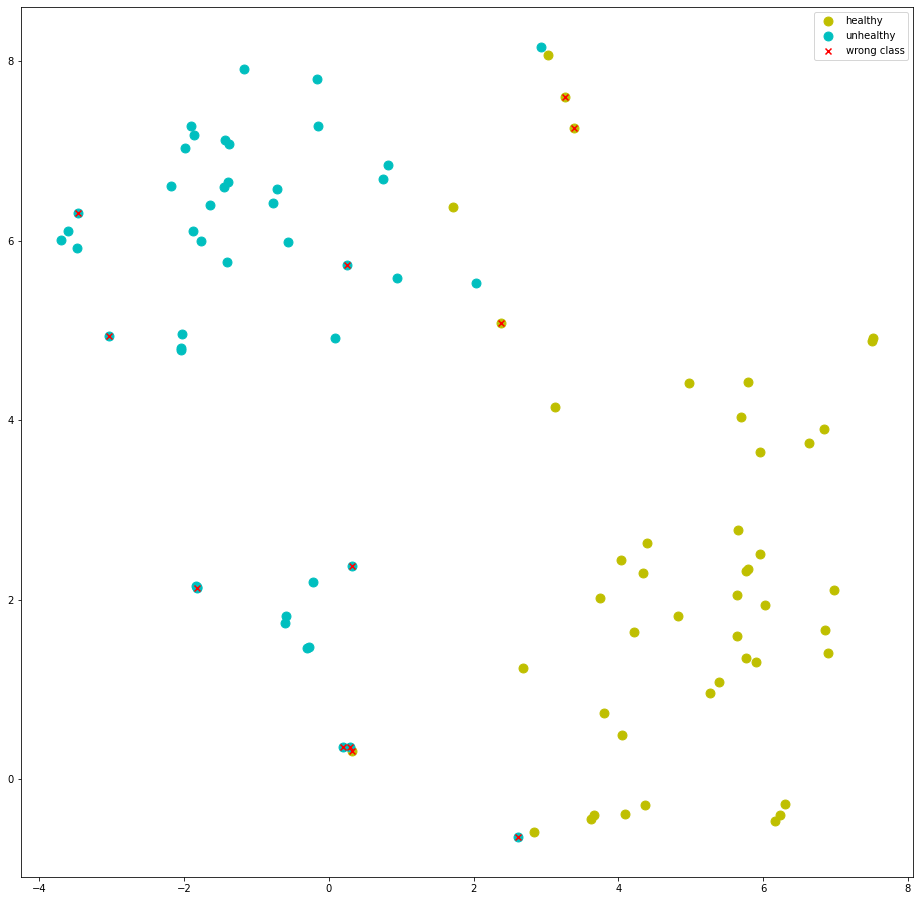

In [12]:
plt.figure(figsize=(16, 16))
plt.scatter(X_2d[pred==0, 0], X_2d[pred==0, 1], c='y', s=80, label='healthy')
plt.scatter(X_2d[pred==1, 0], X_2d[pred==1, 1], c='c', s=80, label='unhealthy')
plt.scatter(X_2d[pred!=y_test, 0], X_2d[pred!=y_test, 1], c='r', marker='x', label='wrong class')
plt.legend()
plt.show()

The blue clusters turned out to be valid. However, the lower the accuracy of the model and the bigger the dataset you are working with the more often there will be cases where a cluster which is identified as "probably safe" contains data points which are wrongly classified. Therefore, you could assign each cluster some kind of certainty value which you evaluate based on a huge dataset. This way the method can be applied to problems where classes are partly overlapping.

## LIME

The main idea of this method is to approximate complicated black-box model by a simpler glass-box one. Usually used with problems having very large explanatory variables. In that case the simpler glass-box model is easier to interpret. The main idea is to train a simpler glass-box model on artificial data so that it approximates the predictions of a complicated black-box model (on these data). We decided to use this method in our problem, as medical data usually are complicated and contain a lot various variables, which are important for explanations. 
We learned about this method in [Molnar, 2021. Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/) book and in [Biecek and Burzykowski, 2020. Explanatory Model Analysis](https://ema.drwhy.ai) book.

##### WHY, WHO, WHAT, WHEN, WHERE, HOW method:

- Why should one use LIME method?
    - The simpler glass-box, which is implemented based on the black-box model and is easier to interpret.
- Who would benefit from it?
    - Model developers, as implemented method would make their work easier and faster, also more understandable.
- What could be visualised?
    - Probabilities of the most important (for decisions) features and their influence (positive or negative, how big) on the model prediction.
- When is this method used?
    - It can be used not only after training to evaluate our model, but also during training. For example if we see that some of the features are never important for training, we might consider trying to reduce number of features and seeing, if it changed the accuracy (or other method of evaluation model prediction). Here we used it in both cases.
- Where could LIME method be used?
    - It could be used for a lots of models, one of them is random forest. Also is usually used to help explain problems, which have a lot of various features. 
- How can this method explain model?
    - The simpler glass-box model is trained on artificial data in that way, that its predictions are similar to the predictions of original model. 

Below we implement LIME method and present some of the local explanations.

In [13]:
explainer = lime_tabular.LimeTabularExplainer(
 training_data=np.array(X_train),
 feature_names=headers[:-1],
 class_names=[1, 0],
 mode='classification'
)

In [14]:
for i in [4,7,8]:
    exp = explainer.explain_instance(
     data_row=X_test[i], 
     predict_fn=clf.predict_proba
)
    print("Row number:" +str(i))
    exp.show_in_notebook(show_table=True)
  

Row number:4


Row number:7


Row number:8


Above shown three results are examples of different probabilities and certainty of the model. In the row 7 & 8 our model was really sure, that the prediction made is correct. So it has nearly no problems in saying, if provided person has high risk of having heart attack or not. Most (or in 8 row all) features are thought to have values which are typical for predicted class. In the row number 4 the situation is much more different. There the model is only 55% sure of its decision. Some of the values of the features also seems to be typical for ill persons. At the end, here the difference is not that big, it seems more like luck if the model chooses correctly.

We also decided to check which features generally for all test data are considered by method as the ones which usually influence the model the most.

In [15]:
# This might take some time
prob_features= []
for i in range(X_test.shape[0]):
    exp = explainer.explain_instance(
     data_row=X_test[i], 
     predict_fn=clf.predict_proba
)
    prob_features.append(exp.as_list())

### Most Important Feature

We take into consideration rows grouped by the predicion. We then try to answer questions: what was the most important feature when predicted illness and what if healthy?

In [16]:
output_0 = [idx for idx, element in enumerate(y_pred) if element==0]
output_1 = [idx for idx, element in enumerate(y_pred) if element==1]

In [17]:
first_decisive_0=[] #set of values which are the most important while deciding
for i in output_0:
    first_decisive_0.append(prob_features[i][0][0])
set_first_decisive_0=set(first_decisive_0)
#count the occurencies of each of them
dict_0=dict((x,first_decisive_0.count(x)) for x in set(set_first_decisive_0))
sorted_dict_0 = sorted(dict_0.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_dict_0)

[('oldpeak > 1.50', 25), ('cp <= 0.00', 18), ('caa <= 0.00', 1), ('2.00 < thall <= 3.00', 1), ('thall <= 2.00', 1)]


In [18]:
first_decisive_1=[] #set of values which are the most important while deciding
for i in output_1:
    first_decisive_1.append(prob_features[i][0][0])
set_first_decisive_1=set(first_decisive_1)
#count the occurencies of each of them
dict_1=dict((x,first_decisive_1.count(x)) for x in set(set_first_decisive_1))
sorted_dict_1 = sorted(dict_1.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_dict_1)

[('caa <= 0.00', 22), ('cp <= 0.00', 12), ('oldpeak > 1.50', 8), ('thall <= 2.00', 3)]


As we see, the values of the features considered are mostly common in a group, at least for ill people. Most of them had less or equal to 0 number of major vessels, which means they had 0, because the values are between 0 and 3. The name of the feature seems to say us, why it was the most important feature. For people considered as more healthy, there was not such a big agreement, which feature helps the most with predictions. Some of the values of 'oldpeak', 'caa' and 'cp' were considered as the most commonly chosen as the most important.

However, the amount of data in our set is not that big and because of that we decided to look on the summary of the most used but first three features for every group.

### Three Most Important Features

In [19]:
three_decisive_0=[] #set of values which are the most important while deciding
for i in output_0:
    three_decisive_0.append(prob_features[i][0][0])
    three_decisive_0.append(prob_features[i][1][0])
    three_decisive_0.append(prob_features[i][3][0])
set_three_decisive_0=set(three_decisive_0)
#count the occurencies of each of them
dict_0_3=dict((x,three_decisive_0.count(x)) for x in set(three_decisive_0))
sorted_dict_0_3 = sorted(dict_0_3.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_dict_0_3)

[('cp <= 0.00', 40), ('oldpeak > 1.50', 25), ('thalachh <= 140.00', 17), ('2.00 < thall <= 3.00', 16), ('caa > 1.00', 9), ('caa <= 0.00', 7), ('thall <= 2.00', 7), ('oldpeak <= 0.00', 5), ('0.00 < exng <= 1.00', 4), ('exng <= 0.00', 3), ('0.00 < caa <= 1.00', 3), ('thalachh > 169.00', 1), ('1.00 < cp <= 2.00', 1)]


In [20]:
three_decisive_1=[] #set of values which are the most important while deciding
for i in output_1:
    three_decisive_1.append(prob_features[i][0][0])
    three_decisive_1.append(prob_features[i][1][0])
    three_decisive_1.append(prob_features[i][2][0])
set_three_decisive_1=set(three_decisive_1)
#count the occurencies of each of them
dict_1_3=dict((x,three_decisive_1.count(x)) for x in set(set_three_decisive_1))
sorted_dict_1_3 = sorted(dict_1_3.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_dict_1_3)

[('caa <= 0.00', 39), ('thall <= 2.00', 37), ('cp <= 0.00', 12), ('2.00 < thall <= 3.00', 8), ('oldpeak > 1.50', 8), ('1.00 < cp <= 2.00', 8), ('oldpeak <= 0.00', 8), ('exng <= 0.00', 5), ('thalachh <= 140.00', 4), ('0.00 < caa <= 1.00', 3), ('0.00 < oldpeak <= 0.60', 2), ('caa > 1.00', 1)]


Here also for ill people number of major vesses equals to 0 seems to be the most important factor, but also apeared that small values of 'thall' are one of the main factors. Also for healthier people 'oldpeak' and 'caa' seem to be the most useful features while carrying out a classification. What is interesting and for sure not intuitive, is that in these results we see nothing about age of the patient. So maybe it is worth trying to train the model without this variable and see what happens?

### Different Model
As stated before, we wanted to try what would happen with the accuracy of the model if we delete feature 'age'. To see it, we will not only look on the accuracy of the model, but also compare number of health and ill people predicted for both situations. It is because we can try find out how many of them will change if we delete 'age' from training.

In [21]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0.0: 46, 1.0: 45}

In [22]:
importance=clf.feature_importances_
importance[::-1].sort()
for i,v in enumerate(importance):
    print('Feature:'+headers[i]+', Score: %.5f' % (v))

Feature:age, Score: 0.15212
Feature:sex, Score: 0.15080
Feature:cp, Score: 0.13764
Feature:trtbps, Score: 0.11176
Feature:chol, Score: 0.09966
Feature:fbs, Score: 0.07596
Feature:restecg, Score: 0.06715
Feature:thalachh, Score: 0.05772
Feature:exng, Score: 0.05587
Feature:oldpeak, Score: 0.03587
Feature:slp, Score: 0.02915
Feature:caa, Score: 0.02132
Feature:thall, Score: 0.00498


In [23]:
headers_without_age, data_array_without_age = data[0][1:], np.asarray(data[1:], dtype=float)[:,1:]
X_without_age, y_without_age = data_array_without_age[:, :-1], data_array_without_age[:, -1]
data_array_without_age

array([[  1.,   3., 145., ...,   0.,   1.,   1.],
       [  1.,   2., 130., ...,   0.,   2.,   1.],
       [  0.,   1., 130., ...,   0.,   2.,   1.],
       ...,
       [  1.,   0., 144., ...,   2.,   3.,   0.],
       [  1.,   0., 130., ...,   1.,   3.,   0.],
       [  0.,   1., 130., ...,   1.,   2.,   0.]])

In [24]:
# Look for the ideal hyperparameters for the Random Forest
hyp_grid = {
    "n_estimators": [10, 50, 100, 150, 200],
    "criterion": ["entropy", "gini"],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "random_state": [66]
}

HS_2 = Hyperparameter_Search(model_class=RandomForestClassifier, hyp_grid=hyp_grid, scaler=StandardScaler,
                           random_state=66)
HS_2.hyperparameter_search(X=X_without_age, y=y_without_age, n_folds=5)

hyp_2 = HS_2.get_best_combo()

In [25]:
# Train new Random Forest
X_train_without_age, X_test_without_age, y_train_without_age, y_test_without_age = train_test_split(X_without_age, y_without_age, test_size=0.3, random_state=66, shuffle=True, stratify=None)


clf_without_age = RandomForestClassifier(**hyp_2)
clf_without_age.fit(X_train_without_age, y_train_without_age)

y_pred_without_age = clf_without_age.predict(X_test_without_age)
accuracy_without_age = accuracy_score(y_test_without_age, y_pred_without_age)
print("Accuracy of the Random Forest:", accuracy_without_age)


Accuracy of the Random Forest: 0.8791208791208791


In [26]:
importance_without_age=clf_without_age.feature_importances_
importance_without_age[::-1].sort()
for i,v in enumerate(importance_without_age):
    print('Feature:'+headers_without_age[i]+', Score: %.5f' % (v))

Feature:sex, Score: 0.18830
Feature:cp, Score: 0.12913
Feature:trtbps, Score: 0.11612
Feature:chol, Score: 0.11241
Feature:fbs, Score: 0.10771
Feature:restecg, Score: 0.09467
Feature:thalachh, Score: 0.07136
Feature:exng, Score: 0.05566
Feature:oldpeak, Score: 0.05198
Feature:slp, Score: 0.04405
Feature:caa, Score: 0.02466
Feature:thall, Score: 0.00394


In [27]:
y_differences=y_pred-y_pred_without_age
unique_diff, counts_diff = np.unique(y_differences, return_counts=True)
dict(zip(unique_diff, counts_diff))

{-1.0: 3, 0.0: 88}

To sum up above results: the accuracy did not change significantly. Also not many labels are different - only three out of ninty one changed. It means that variable 'age' does not contain much new informations relevant to the model, which other features do not contain. We believe that the older the person, the statistically worster its health, and the values of other features show this. That is why the results do not change much when we delete this feature.

## Explainable Matrix

The concept of Explainable Matrix for Random Forest interpretability was first introduced by Neto and Paulovich (2020). This visualization method uses a matrix representation to visualize large quantities of Random Forest's decision rules. Using this method, one can create both local and global explanations and thus analyze either an entire model or audit concrete classification results. 

In [28]:
# Train a tiny forest for demostration of EX
n_trees = 2
max_depth = 3

tiny_clf = RandomForestClassifier(n_estimators=n_trees,
                                  max_depth=max_depth,
                                  random_state=66)
tiny_clf.fit(X_train, y_train)
y_pred = tiny_clf.predict(X_test)
tiny_accuracy = round(accuracy_score(y_test, y_pred), 3)


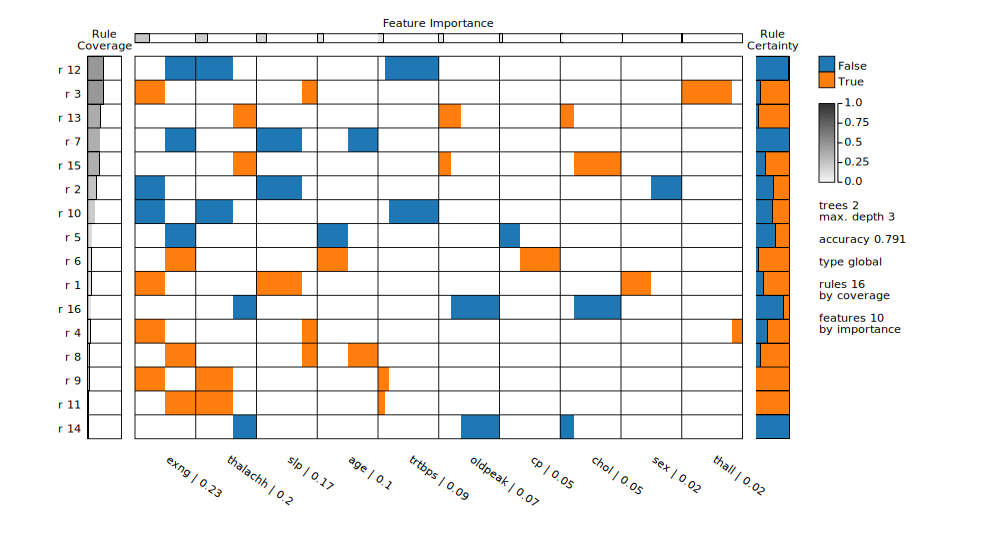

In [29]:
# Create the EX matrix for the tiny forest
exm = ExplainableMatrix(
    n_features=len(headers)-1,
    n_classes =len(np.unique(y)),
    feature_names=np.array(headers)[:-1],
    class_names=np.array(["False","True"])
)

exm.rule_extration(
    skl_trees=tiny_clf, 
    X=X, 
    y=y, 
    feature_importances=tiny_clf.feature_importances_,
    calc_diameter=True
)

# Create a viz. of the global explanation of the random forest
exp = exm.explanation(
    exp_type="global",
    r_order="coverage",
    f_order="importance",
    info_text=f"\ntrees {n_trees}\nmax. depth {max_depth}\n\naccuracy {tiny_accuracy}\n"
)


exp.create_svg(draw_row_labels=True, draw_col_labels=True,
               draw_rows_line=True, draw_cols_line=True,
               col_label_degrees=35,
               width=2200, height=1200, margin_bottom=225)

exp.save("images/small_example_heart_glob.png", pixel_scale=1)
exp.display_jn()

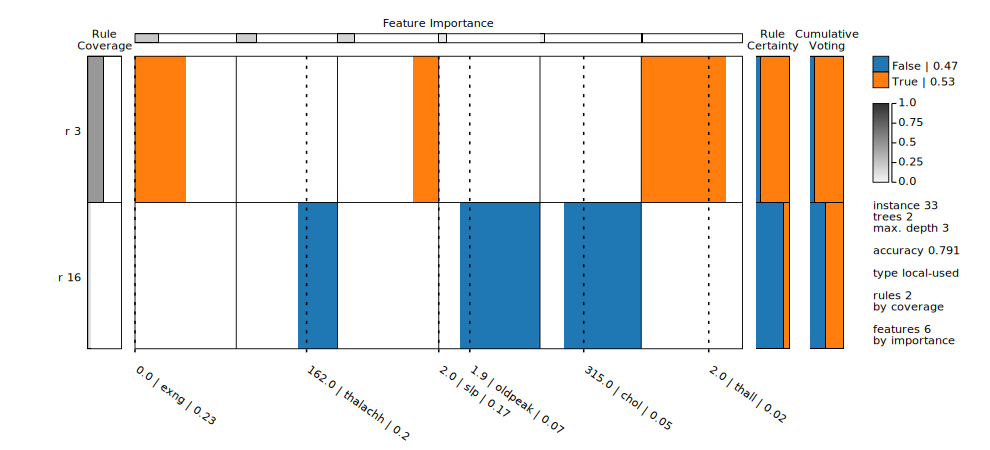

In [30]:
# Create a viz. of the local explanation of the random forest
i_instance = 33

exp = exm.explanation(
    exp_type="local-used",
    x_k=X_test[i_instance],
    r_order="coverage",
    f_order="importance",
    info_text=f"\ninstance {i_instance}\ntrees {n_trees}\nmax. depth {max_depth}\n\naccuracy {tiny_accuracy}\n"
)

exp.create_svg(draw_row_labels=True, draw_col_labels=True,
               draw_rows_line=True, draw_cols_line=True,
               draw_x_k=True, col_label_degrees=35,
               width=2200, height=1000, margin_bottom=225)

exp.save("images/small_example_heart_loc.png", pixel_scale=1)
exp.display_jn()

### Global Explanation

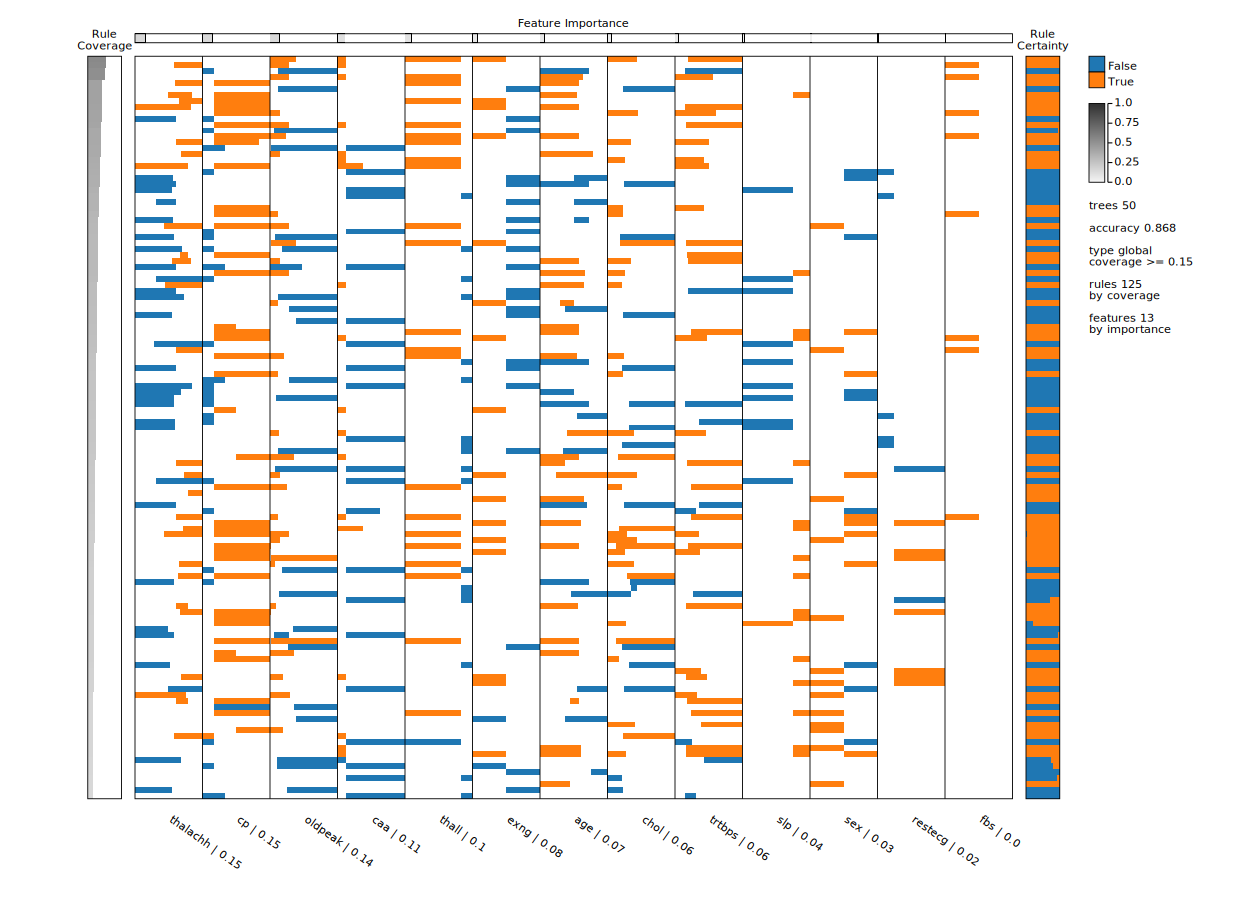

In [31]:
# Our Model
n_trees = hyp["n_estimators"]

# Create the EX matrix for the forest
exm = ExplainableMatrix(
    n_features=len(headers)-1,
    n_classes =len(np.unique(y)),
    feature_names=np.array(headers)[:-1],
    class_names=np.array(["False","True"])
)

exm.rule_extration(
    skl_trees=clf, 
    X=X, 
    y=y, 
    feature_importances=clf.feature_importances_,
    calc_diameter=True
)

# Create a viz. of the global explanation of the random forest no filter
exp = exm.explanation(
    exp_type="global",
    r_order="coverage",
    f_order="importance",
    info_text=f"\ntrees {n_trees}\n\naccuracy {round(accuracy, 3)}\n"
)


exp.create_svg(draw_row_labels=False, draw_col_labels=True,
               draw_rows_line=False, draw_cols_line=True,
               col_label_degrees=35,
               width=2800, height=2000, margin_bottom=225)

exp.save("images/our_heart_glob.png", pixel_scale=1)

# Create a viz. of the global explanation of the random forest filter
exp = exm.explanation(
    exp_type="global",
    r_coverage=0.15,
    r_order="coverage",
    f_order="importance",
    info_text=f"\ntrees {n_trees}\n\naccuracy {round(accuracy, 3)}\n"
)


exp.create_svg(draw_row_labels=False, draw_col_labels=True,
               draw_rows_line=False, draw_cols_line=True,
               col_label_degrees=35,
               width=2800, height=2000, margin_bottom=225)

exp.save("images/our_heart_glob_filter.png", pixel_scale=1)
exp.display_jn()

The goal of global explanation is to provide description of the whole Random Forest based on its decision rules. Figure 5 contains the global explanation of our forest. The forest contains in total 1543 rules which rely on 13 features. In the matrix, the rules are ordered based on the rule coverage and features based on their importance. At the first glance, one can clearly see that features resting electrocardiographic results (restecg) and fasting blood sugar (fbs) are used only in few instances and thus have a low importance. Removing these features may prove to be beneficial for the simplicity and overall performance of the forest. By looking closely at individual features and rules, patters in the predicate ranges emerge. These patterns become more pronounced once the focus is on rules with higher coverage. Figure 6 provides the same view as figure 5 but only with the rules with coverage greater than 0.15. For the most important feature, maximum heart rate achieved (thalach), the predicate ranges indicate that patients with higher values tend to be classified as being at higher risk of getting a heart attack. On the other hand, for example, higher risk patients tend to have lower oldpeak value then the other low risk patients.

### Local Explanation

In [32]:
# Patient number 33
i_instance = 33
print(f"Patient number: {i_instance}")
for i in range(len(X_test[i_instance])):
    print(f" {headers[i]}: {X_test[i_instance][i]}")

print(f"\nLabel: {y_test[i_instance]}")

Patient number: 33
 age: 43.0
 sex: 1.0
 cp: 2.0
 trtbps: 130.0
 chol: 315.0
 fbs: 0.0
 restecg: 1.0
 thalachh: 162.0
 exng: 0.0
 oldpeak: 1.9
 slp: 2.0
 caa: 1.0
 thall: 2.0

Label: 1.0


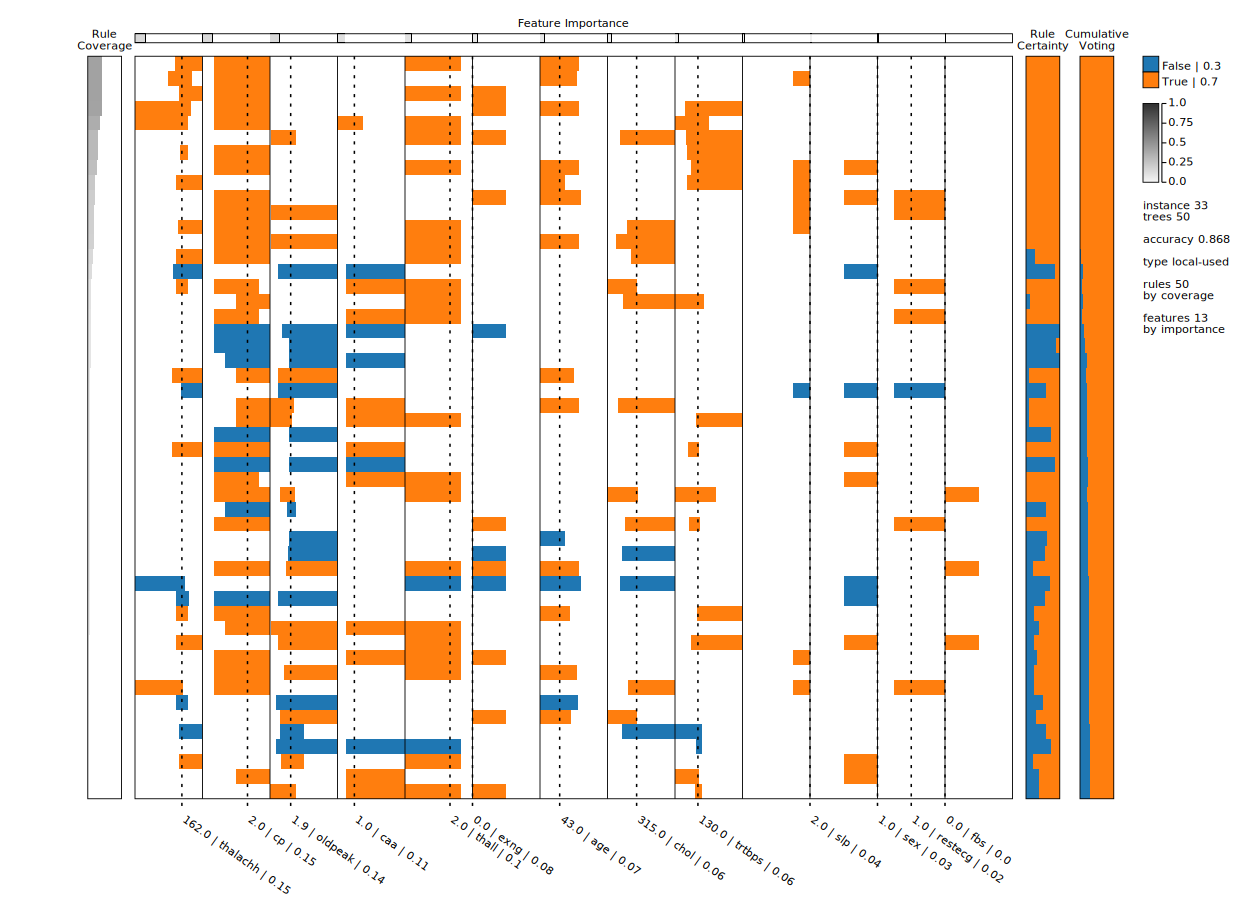

In [33]:
# Create a viz. of the local explanation of the random forest
exp = exm.explanation(
    exp_type="local-used",
    x_k=X_test[i_instance],
    r_order="coverage",
    f_order="importance",
    info_text=f"\ninstance {i_instance}\ntrees {n_trees}\n\naccuracy {round(accuracy, 3)}\n"
)

exp.create_svg(draw_row_labels=False, draw_col_labels=True,
               draw_rows_line=False, draw_cols_line=True,
               draw_x_k=True, col_label_degrees=35,
               width=2800, height=2000, margin_bottom=225)

exp.save("images/our_heart_loc.png", pixel_scale=1)
exp.display_jn()


In a hypothetical scenario, a doctor is informed that his patient, based on his current medical records, may be at a high risk of getting a heart attack. After looking at the patient’s records, the doctor is not fully convinced with the model’s decision and decides to contact the technical support to ask them to audit the model’s decision. Technician from the technical support team creates a local explanation using the Explainable Matrix (figure 7) for this specific patient and inspects the decision rules which led to the conclusion that this patient is at a high risk. Even though the patient's values for the two most important features (thalach, oldpeak) are often at the borders of the predicate ranges, majority of the rules with high coverage classify the patient as being at risk with complete certainty. This decision is contradicted by some more specialized rules; however, their rule certainty is often very low. Looking at these results, the technician is confident with the model’s decision and informs the doctor.